In [140]:
import numpy as np
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib

In [141]:
def fill_theta_matrix(functions, data):
    assert type(data) == type(functions) == np.ndarray
    theta = np.zeros((data.shape[0], functions.shape[0]))
    for i in range(functions.shape[0]):
        function = functions[i]
        theta[:, i] = function(data[:, 0], data[:, 1])
    return theta

In [142]:
def pendulum_rhs(zt, dzt, coefficients, terms):
    #selected_terms =   [lambda x: terms[i]*coefficients[i] for i in range(len(terms)) if abs(coefficients[i]) > 1E-12]
    filled_theta_matrix = fill_theta_matrix(terms, np.array([zt, dzt]).T)
    return filled_theta_matrix @ coefficients.T
    

In [143]:
def pendulum_ode_step(y, t, coefficients, terms):
    zt, dzt = y
    return [dzt, *pendulum_rhs(np.array([zt]), np.array([dzt]), coefficients, terms)[0]]

In [144]:
def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t = np.linspace(0, dt * T, T)
    sol = odeint(pendulum_ode_step, np.array([z0, dz0]),t, args=(coefficients, terms))
    return sol, t

In [145]:
coeff = np.array([[-5, 0, 0, -0.25]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
sol, t = simulate_pendulum(np.pi-0.1, 0, coeff,terms, 100, 0.1)

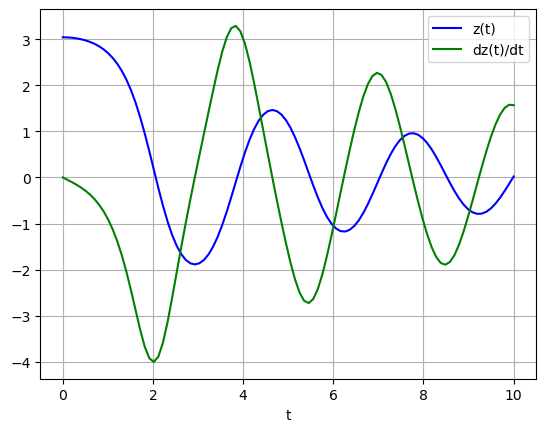

In [146]:
plt.plot(t, sol[:, 0], 'b', label='z(t)')
plt.plot(t, sol[:, 1], 'g', label='dz(t)/dt')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

This is consistent with the example results from https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
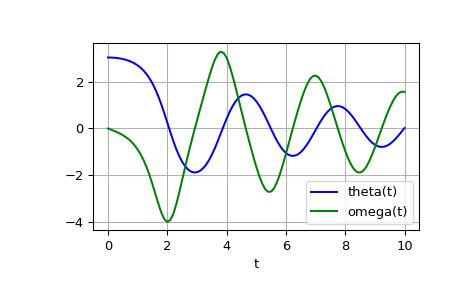

$\frac{1}{2}\dot{z}_0^2 - \cos(z) \leq 0.99 \implies \dot{z}_0 \leq \sqrt{2(0.99 + \cos(z_0))}$

In [468]:
def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding = None, rejection = True):
    dom_z = np.linspace(z0_min, z0_max, 1000)
    dom_dz = np.linspace(dz0_min, dz0_max, 1000)
    initial_conditions = []
    for i in range(N):
        generated = False
        index = 0
        while not generated:
            z_0 = np.random.choice(dom_z)
            possible_dz_indices = np.where(np.abs(0.5*dom_dz**2 - np.cos(z_0)) <= 0.99)[0]
            if len(possible_dz_indices) > 0 or index == 25:
                generated = True
            index += 1
        dz_0 = np.random.choice(dom_dz[possible_dz_indices])

        
        initial_conditions.append(np.array([z_0, dz_0]))
    initial_conditions = np.array(initial_conditions)

    ts = []
    for z_0, dz_0 in initial_conditions:
        print(np.abs(0.5*dz_0**2 - np.cos(z_0)))
        sol, t = simulate_pendulum(z_0, dz_0, coefficients, terms, T, dt)
        ddz = pendulum_rhs(sol[:, 0], sol[:, 1], coefficients, terms)
        ts.append(np.array([sol[:, 0], sol[:, 1], ddz[:, 0]]))
    return ts
        
        
                              

In [542]:
coeff = np.array([[-1, 0, 0, 0]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
data = create_pendulum_data(-1, 1, -2.1, 2.1, coeff, terms, 5000, 0.002, 5, embedding = None, rejection = True)

0.9440151564843988
0.9395759716156734
0.5374631940976431
0.6707380594239176
0.6458537172825147


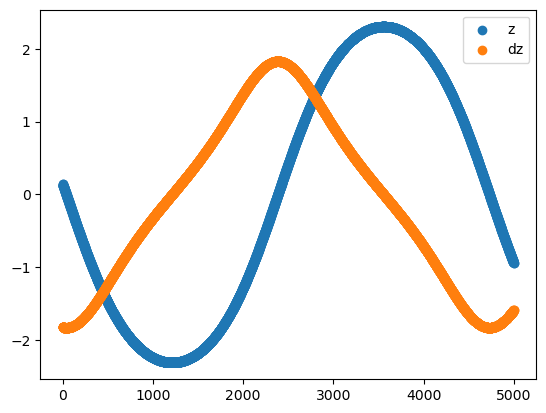

In [548]:
plt.scatter(range(5000), data[3][0], label="z")
plt.scatter(range(5000), data[3][1], label="dz")
plt.legend()

In [545]:
def embed_cartesian(z, dz, ddz):
    x = np.array([np.sin(z), -np.cos(z)])
    dx =  np.array([np.cos(z) * dz, np.sin(z)*dz])
    ddx =  np.array([-np.sin(z) * dz**2 + np.cos(z)*ddz, np.cos(z)+dz**2+np.sin(z)*ddz])
    return np.array([x,dx,ddx])

In [546]:
def create_phase_plot(data):
    fig, axs = plt.subplots(len(data), 3, constrained_layout=True)
    fig.suptitle("Phase portrait", fontsize="x-large")
    for i in range(len(data)):
        simulation = data[i]
        coords = embed_cartesian(*simulation)
        axs[i, 0].scatter(coords[0, 0, :], coords[1, 0, :])
        axs[i, 0].set_xlabel("Position in x")
        axs[i, 0].set_ylabel("Velocity")
        axs[i, 1].scatter(coords[0, 1, :], coords[1, 1, :])
        axs[i, 1].set_xlabel("Position in y")
        axs[i, 1].set_ylabel("Velocity")
        axs[i, 2].scatter(simulation[0, :], simulation[1, :])
        axs[i, 2].set_xlabel("z")
        axs[i, 2].set_ylabel("dz")
    plt.show()

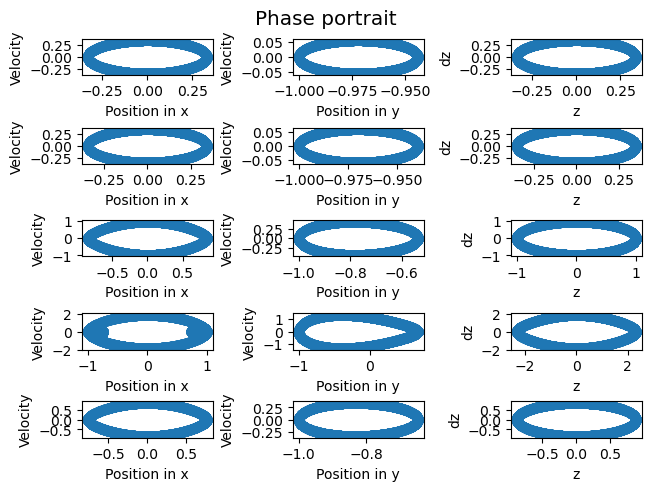

In [547]:
create_phase_plot(data)

In [540]:
x, _, _ = embed_cartesian(*data[2])

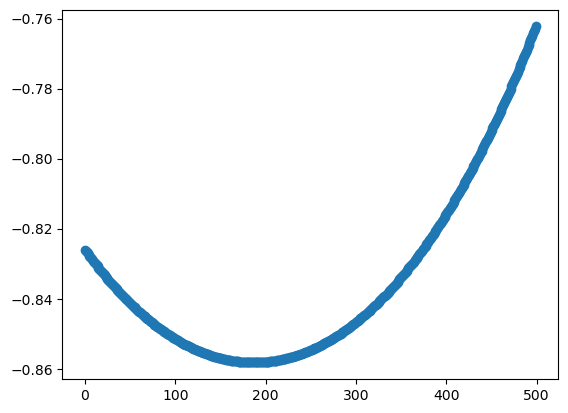

In [541]:
plt.scatter(range(500), x[0])

In [388]:
coeff = np.array([[-1, 0, 0, -0.05]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
dampened_data = create_pendulum_data(-np.pi, np.pi, -2.1, 2.1, coeff, terms, 500, 0.02, 2, embedding = None, rejection = True)

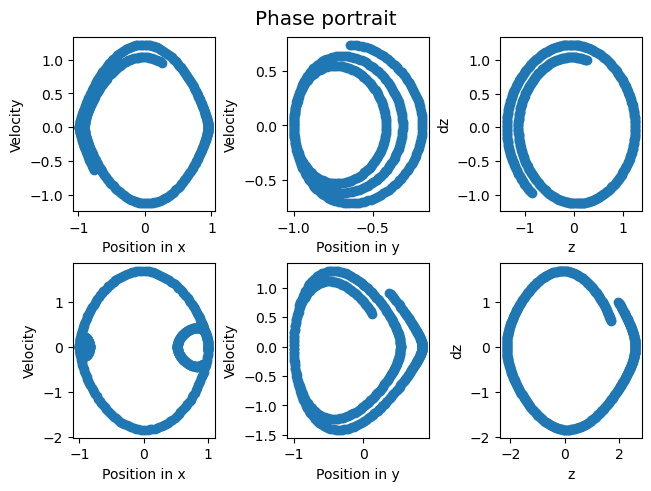

In [389]:
create_phase_plot(dampened_data)

In [4]:
class VariableAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, layers, activation="reLU"):
        assert activaion == "reLU" or activation == "sigmoid"
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layers = layers
        
        self.encoder = [] 
        self.decoder = []
        self.encoder.append(nn.Linear(self.input_size, self.hidden_size))
        self.decoder.append(nn.Linear(1, self.hidden_size))
        
        
        for layer in range(self.layers - 1):
            self.encoder.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.decoder.append(nn.Linear(self.hidden_size, self.hidden_size))
            
            if activation == "reLU":
                self.encoder.append(nn.reLU())
                self.decoder.append(nn.reLU())
            
            if activation == "sigmoid":
                self.encoder.append(nn.Sigmoid())
                self.decoder.append(nn.Sigmoid())
                
        self.encoder.append(nn.Linear(self.hidden_size, 1))
        self.decoder.append(nn.Linear(self.hidden_size, self.input_size))
        
        self.encoder = nn.Sequential(self.encoder)
        self.decoder = nn.Sequential(self.decoder)
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        return self.decode(self.encode(x))
        

    